# 5. Investigating Survival/Recurrace
This notebook is fore exploring the connection between survival rate in TNBC and spacial distribution of TILs.

In [64]:
import pandas as pd
from itertools import combinations
import regex as re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dataset import TNBC2
import os
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})


In [237]:
df_pred1 = pd.read_pickle('../data/tnbc2/tnbc_quip_ds.pickle')
df_pred2 = pd.read_pickle('../data/tnbc2/tnbc.pickle')

In [245]:
df_pred = df_pred1
df_pred = df_pred[df_pred["image_id"] != "TNBC_Block_3_block_1_314054_8_M_HE"]

In [247]:
df_pat = pd.read_excel('../data/tnbc2/256_TNBC__F_LEION_till_arvid.xlsx')
df_pat["treated"] = df_pat["Type treatment (Adj/Neoadj/Met)"].apply(lambda x: int(x != "None"))
df_pat["dead"] = df_pat["Dead yes 1 no 0"]
df_pat["OS"] = df_pat["OS yes 1 no 0"]
df_pat["IDFS"] = df_pat["IDFS yes 1 no 0"]
df_pat["DRFI"] = df_pat["DRFI Breast cancer spec"]
df_pat["relapse"] = df_pat["Relapse yes 1 no 0"]

df_pat = df_pat[df_pat["TILs helsnitt"] > 0] # Missing values
df_pat = df_pat[df_pat["TILs TMA"] > 0] # Missing values

<AxesSubplot:ylabel='Frequency'>

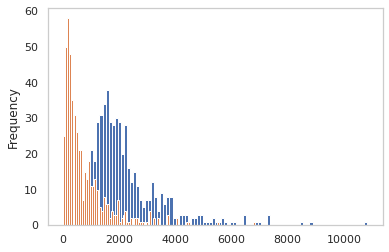

In [248]:
df_pred1["n_immune"].plot.hist(bins=100)
df_pred2["n_immune"].plot.hist(bins=100)

In [249]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def ripleys_k(locations, t=50):
    """en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley.27s_K_and_L_functions"""
    
    n = len(locations)
    within_t = 0
    z = np.array([[complex(x, y) for x, y in locations]])
    distances = abs(z.T-z)
    within_t = np.sum(distances[0] < t)
        
    return np.sqrt(within_t / n)

def _patient_id(image_name):
    block,  nr, letter = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", image_name)[0]
    block_start = [1, 59, 113, 172, 210]
    start = block_start[int(block)-1]
    
    letter = letter.lower()
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    pat_id = key[int(nr)-1][11 - (ord(letter) - 97)]
    return pat_id
    
def _tma_id(patient_id):
    block_start = [1, 59, 113, 172, 210]
    start = [s for s in block_start if patient_id >= s][-1]
    block = block_start.index(start) + 1
            
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    Y, X = np.where(key == patient_id) 
    letters = [chr(11 - (x - 97)).upper() for x in X]
    numbers = list(Y + 1)
    return block, letters, numbers
    
def _image_path(patient_id):
    block, letters, numbers = _tma_id(patient_id)
    paths = []
    dataset = TNBC2()
    for let, num in zip(letters, numbers):
        for file in os.listdir(dataset.image_dir):
            b, n, l = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", file)[0]
            if int(b) == block and int(n) == num and l == let:
                paths.append(dataset.image_dir / file)
    return paths

def display(tma_id):
    plt.figure(figsize=(20,10))
    for n, path in enumerate(_image_path(tma_id), 1):
        plt.subplot(1,2,n)
        plt.imshow(imread(path))
        
def correlation(df, features):
    corrmat = df[features].corr(method='spearman')
    plt.figure(figsize=(8,8))
    sns.clustermap(corrmat, vmin=-1, cmap="YlGnBu", linewidth=0.1, annot=True)
    
def corrfunc(df, **kws):
    x, y = zip(*df.dropna().values)
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.set_title(f"r = {r:.2f}, p = {p:.2E}")

## Split TILs into stromal and intratumoral

<img src="../docs/stromal_intratumoral_tils.png" width="500" align="left"/>


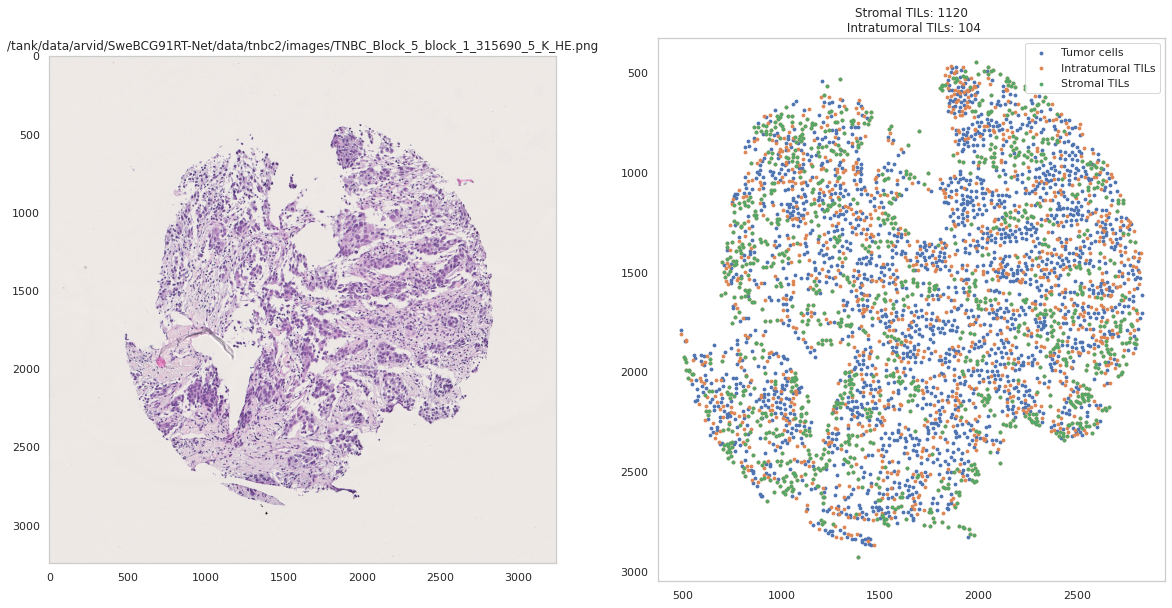

In [230]:
from scipy.spatial import distance

def tumor_stroma_tils(immune_loc, tumor_loc, r=30, factor=2.0):
    """ Estimates which immune cells are Stromal TILs and which
        are Intratumoral."""
    tumor_loc = np.array([list(coord) for coord in tumor_loc])
    immune_loc = np.array([list(coord) for coord in immune_loc])
    
    tumor_dist = distance.cdist(tumor_loc,immune_loc)
    immune_dist = distance.cdist(immune_loc,immune_loc)
    
    tumor_within_r = tumor_dist < r
    immune_within_r = immune_dist < r
    
    n_tumor_within = tumor_within_r.sum(axis=0)
    n_immune_within = immune_within_r.sum(axis=0)
    
    tumor_tils = n_tumor_within > n_immune_within*factor
    stroma_tils = n_tumor_within*factor < n_immune_within

    return immune_loc[tumor_tils], immune_loc[stroma_tils]

size = 8
def display_cells(df):
    tnbc = TNBC2()
    for n, row in df.iterrows():
        immune_loc = row["immune_loc"]
        tumor_loc = row["tumor_loc"]
        imid = row["image_id"]
        img = tnbc.load_image(imid)
        path = tnbc.file_name(imid)

        tumor_tils, stroma_tils = tumor_stroma_tils(immune_loc, tumor_loc)

        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(img)
        plt.title(path)
        plt.subplot(122)
        ax = plt.gca()
        ax.invert_yaxis()
        args = lambda locs: list(zip(*locs))[::-1]
        plt.title(f"Stromal TILs: {len(stroma_tils)}\n Intratumoral TILs: {len(tumor_tils)}")
        plt.scatter(*args(tumor_loc), label="Tumor cells", s=size)
        plt.scatter(*args(immune_loc), label="Intratumoral TILs", s=size)
        plt.scatter(*args(stroma_tils), label="Stromal TILs", s=size)
        plt.legend()
    
display_cells(df_pred.iloc[0:1])

In [92]:
def box(point):
    y, x = point
    s = 15
    x2, x1 = (int(x+s), int(x-s))
    y2, y1 = (int(y+s), int(y-s))
    return slice(y1, y2, None), slice(x1,x2,None)

#for point in immune_loc[0:100]:
#    plt.figure(figsize=(2,2))
#    plt.imshow(img[box(point)])

In [250]:
df_pred = df_pred[df_pred["tumor_loc"].apply(lambda x: len(x) > 0)]
df_pred = df_pred[df_pred["immune_loc"].apply(lambda x: len(x) > 0)]

df_pred["tumor_tils_loc"], df_pred["stroma_tils_loc"] = zip(*[
    tumor_stroma_tils(im, tum) for im, tum in zip(df_pred["immune_loc"].values, df_pred["tumor_loc"].values)
])

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [251]:
df_pred["immune_cluster"] = df_pred["immune_loc"].apply(ripleys_k)
df_pred["tumor_cluster"] = df_pred["tumor_loc"].apply(ripleys_k)

In [252]:
df_pred["stroma_tils"] = (df_pred["stroma_tils_loc"].apply(len))
df_pred["tumor_tils"] = (df_pred["tumor_tils_loc"].apply(len))
df_pred["percent_intratumoral_tils"] = df_pred["tumor_tils"] / df_pred["n_immune"]# / df_pred["n_immune"])

In [255]:
df_pred["TMAid"] = df_pred["image_id"].apply(_patient_id)
df_pred_merged = df_pred.groupby("TMAid").mean().reset_index()
df_all = pd.merge(df_pat, df_pred_merged, how='inner', on=["TMAid"])

df_all["TILs cutoff"] = df_all["TILs helsnitt"].apply(lambda x : int(x>0.27))


## Comparision of estimated estimations by models and humans
We compare the features estimated by the cell detector and features estimated by humans.

`TILs helsnitt` and `TILs TMA` are the estimated share of stromal area coverd by stromal TILs in the WSIs and TMAs. This has been done according to the recommendations by the [International TILs Working Group 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6267863/).

`n_tumor` and `n_immune` are the estimated number of tumor and immune cells in the TMA images.

`tumor_tils` and `stromal_tils` is the estimated number of intratrumoral TILs and stromal TILs in the TMA images.

In [256]:
def plot_compare(ylabels, xlabels, df=df_all):
    plt.figure(figsize=(5*len(ylabels),4))
    features = [[x, y] for x in xlabels for y in ylabels]
    for n, feat in enumerate(features, 1):
        plt.subplot(1,len(ylabels),n)
        sns.scatterplot(data=df, x=feat[0], y=feat[1])
        corrfunc(df[feat])

`n_immune` has a high correlation with TILs helsnitt and TILs TMA

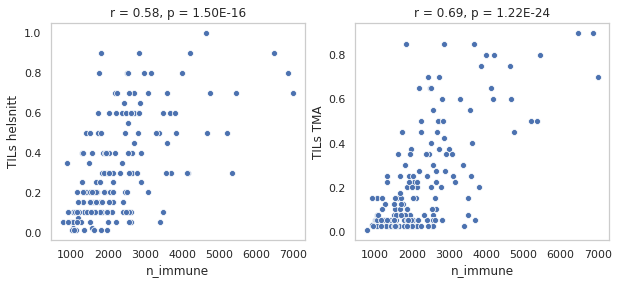

In [257]:
plot_compare(["TILs helsnitt", "TILs TMA"], ["n_immune"])

`stroma_tils`'s correlation is not as strong

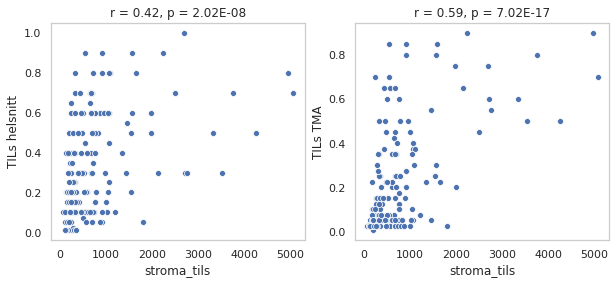

In [258]:
plot_compare(["TILs helsnitt", "TILs TMA"], ["stroma_tils"])

 ...`tumor_tils` correlation is however only statistically significant 
 with the WSI's estimate of stromal TILs area share.

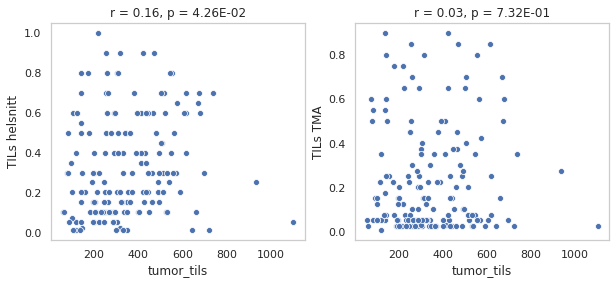

In [259]:
plot_compare(["TILs helsnitt", "TILs TMA"], ["tumor_tils"])

 ...the percent of TILs that are estimated to be intratumoral
 has a _negative_ correlation with the other features.

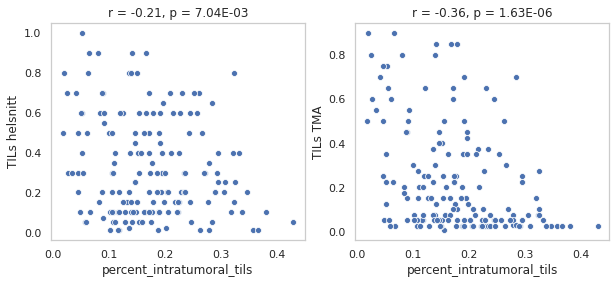

In [260]:
plot_compare(["TILs helsnitt", "TILs TMA"], ["percent_intratumoral_tils"])

`n_immune` has a poor and insignificant correlation with Age at diagnosis.
This suggest that maybe the estimated approach recommended by the 
International TILs working group is measuring something that is not captured
by our apporach.

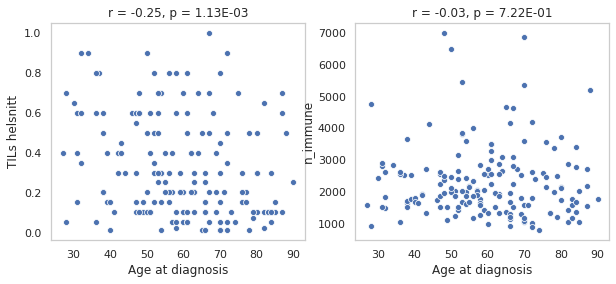

In [268]:
plot_compare(["TILs helsnitt","n_immune"],
             ["Age at diagnosis"])

## Treated cohort
Investigating all the patiens who received treatment.

Having many tumor cells leads to having distant mets sooner. This makes sense.

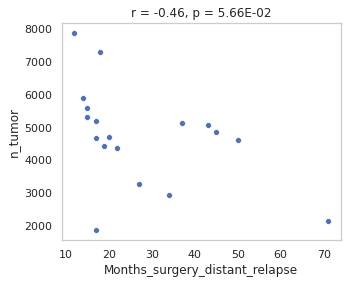

In [269]:
df_treated = df_all[df_all["treated"] == 1]
plot_compare(["n_tumor"], ["Months_surgery_distant_relapse"], df_treated)

The following correlations are strange because they suggest that it's bad to have a high share of stromal TILs area and a high percent of intratumoral TILs. It could be that having more tumor cells makes more of the immune cells count as intratumoral since they are more likely to be surrounded by tumor cells. This could indicate that our metric is flawed. However, it might not be the whole story since the correlation and significance is slightly higher than the example above.

It could be that `TILs TMA` , `TILs helsnitt` and `percent_intratumoral_tils` are all caused by having a real nasty tumor which also causes a sooner relapse...

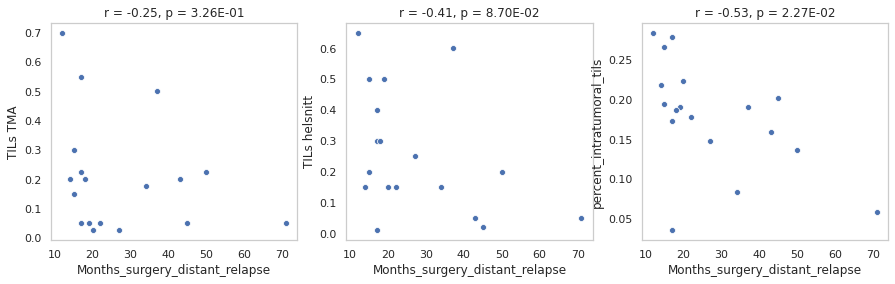

In [270]:
plot_compare(["TILs TMA", "TILs helsnitt", "percent_intratumoral_tils"], ["Months_surgery_distant_relapse"], df_treated)

Having TILs in clusters seems to be good.

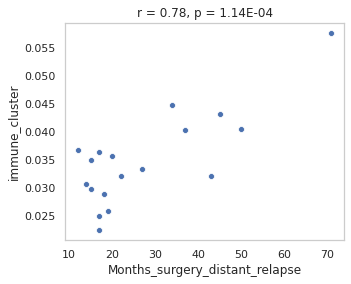

In [283]:
plot_compare(["immune_cluster"], ["Months_surgery_distant_relapse"], df_treated)

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,coef,std err,z,P>|z|,[0.025,0.975]
n_tumor,-0.000124,0.00040,-0.16088,0.50984,-0.00108,0.00088
n_immune,0.000713,0.00100,0.66148,0.54420,-0.00128,0.00280
tumor_tils,-0.001292,0.00556,-0.23968,0.56152,-0.01204,0.00952
stroma_tils,-0.001780,0.00184,-0.92432,0.39476,-0.00532,0.00188
immune_cluster,-36.681932,33.06084,-1.07848,0.36300,-101.47968,28.11596
tumor_cluster,5.093680,37.69768,0.11880,0.68216,-68.79276,78.97996


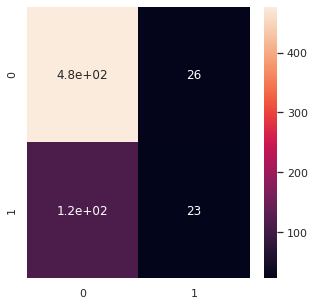

In [282]:
import statsmodels.api as sm
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sn

features = [
    'n_tumor',
    'n_immune',
    'tumor_tils',
    'stroma_tils',
    'immune_cluster',
    'tumor_cluster',
]
classes = ["dead"]
df = df_treated[features + classes].dropna()
X = df[features]
y = df[classes]
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

def _results_to_pandas(summary):
    return pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

cm_list = []
results = []
outer_results = []
for train_val_idx, test_idx in cv_outer.split(X):
    X_train_val, X_test = X.iloc[train_val_idx, :], X.iloc[test_idx, :]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
        
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_idx, val_idx in cv_inner.split(X_train_val):
        x_train, x_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        model = sm.Logit(y_train, x_train).fit(disp=False)
        #model = RandomForestClassifier()
        #model.fit(x_train.values, y_train.values.ravel())
        y_pred = np.around(model.predict(x_val))
        cm_list.append(confusion_matrix(y_val, y_pred))
        results.append(_results_to_pandas(model.summary()))
            
            

df_cm = pd.DataFrame(np.sum(cm_list, axis=0))
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True)
sum(results) / len(results)